# BL40A2010 Introduction to IoT-Based Systems

## Tutorial 7: *IoT-based systems*

## Author: Pedro Nardelli

In [16]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import glob
import os
import zipfile
import sys
from time import time

### Case study: Power grid frequency

This tutorial will try to replicate this figure from the German power grid as described in the article discussed in the lecture and in this [recent one from Nature Energy](https://www.ds.mpg.de/3175383/180108-pm-netzwerke). 

![](https://www.ds.mpg.de/3209041/original-1518437713.jpg?t=eyJ3aWR0aCI6ODAwLCJoZWlnaHQiOjYwMCwib2JqX2lkIjozMjA5MDQxfQ==--19ce4ee80945bee229d6d6cb4e868168e0620ded)[Source link](https://arxiv.org/pdf/1807.08496.pdf)

We will use the frequency from [Finnish Power Grid](https://data.fingrid.fi/en/dataset/frequency-historical-data) availbale for download.

### One day test

In [2]:
#https://data.fingrid.fi/en/dataset/frequency-historical-data
#1.1.2018
data20180101 = pd.read_csv("2018-01-01.csv",header=0, parse_dates=True, sep=',',index_col=0)                         
data20180101.head()

,Value
Time,
2018-01-01 00:00:00.000,50.026
2018-01-01 00:00:00.100,50.027
2018-01-01 00:00:00.200,50.027
2018-01-01 00:00:00.300,50.027
2018-01-01 00:00:00.400,50.028


Data has too high resolution (miliseconds), so I will resample by taking the it making the mean value of 10 seconds. This value can be changed.

In [3]:
#testing: 5 elements and 10 seconds
data20180101.resample('10S').mean()[0:5]

,Value
Time,
2018-01-01 00:00:00,50.03330
2018-01-01 00:00:10,50.01508
2018-01-01 00:00:20,49.99173
2018-01-01 00:00:30,49.96801
2018-01-01 00:00:40,49.95665


Plotting the full dataset resampled 

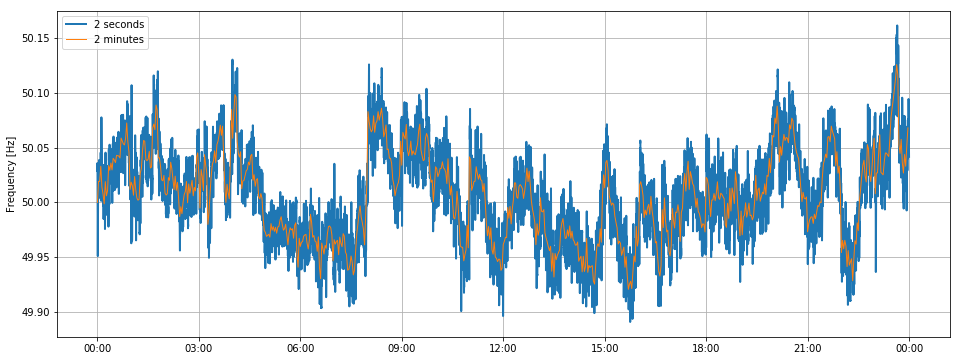

In [18]:
#Plot - all elements 1 second resolution
fig, ax = plt.subplots(1,figsize=(16,6))
#2 seconds
plt.plot(data20180101.resample('2S').mean(), linewidth=2,label='2 seconds')
#2 minutes
plt.plot(data20180101.resample('2T').mean(),linewidth=1,label='2 minutes')
plt.ylabel("Frequency [Hz]") 
plt.grid(True)
#change x ticks
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.legend()
#
plt.show() 

## Let's take the whole month

In [6]:
tbeg = time()  # time tracking
base_date = '2016-05'    # choose month (remember to upload file to the folder!)

# check whether the HDF5 file was previously created
if len(glob.glob(base_date+'.hdf')) > 0:
    print('Loading file {:}.hdf...'.format(base_date), end=' ')
    data = pd.read_hdf(base_date+'.hdf')
    print('done.'.format(base_date))
else:  # if HDF file doesn't exist, try to create it
    print('{:}.hdf not found, creating...'.format(base_date))
    data = pd.DataFrame()
    try:
        # uncompress ZIP file of the desired date inside the base_date folder
        print('Locating and extracting files for {:}...'.format(base_date))
        zip_ref = zipfile.ZipFile(base_date+'.zip',"r") 
        flist = zip_ref.namelist()  # get the list of files inside the ZIP archive
        count = 0
        prog = len(flist)*['-']
        print('Appending {:} files to DataFrame...'.format(len(flist)))
        for f in flist:
            zf = zip_ref.open(f)#, base_date)
            try:
                data = data.append(pd.read_csv(zf, header=0, parse_dates=True, sep=',', index_col=0))
                prog[count] = '*'  # marker for loaded file
            except Exception:  # generic exception, the one from Pandas is not catch-able (?)
                prog[count] = '?'  # marker for empty file (2017-08-06, for example)

            # Simple progress bar
            sys.stdout.write('\r')
            sys.stdout.write("%-s %3d%%" % (''.join(prog), (100*(count+1))/len(flist)))
            sys.stdout.flush()
            count += 1

        # close zip file
        zip_ref.close()
        print()
        # Print warning message for zero-sized files
        if any([prog[i] == '?' for i in range(len(prog))]):
            print('Warning: Some files are incomplete/missing.')

        # Generate compressed HDF5 file with the CSV files
        data.to_hdf(base_date+'.hdf', 'freq_'+base_date.replace('-', '_'), complib='lzo', complevel=9, mode='w')
        print('Done. You may delete file "{:}.zip" to save space'.format(base_date))
        del zf, f, count, flist
    except FileNotFoundError:
        print("Not found! Check script folder for '{:}.zip' file".format(base_date))
print('Elapsed time: {:6.3f}s'.format(time()-tbeg))

2016-05.hdf not found, creating...
Locating and extracting files for 2016-05...
Appending 31 files to DataFrame...
******************************* 100%
Done. You may delete file "2016-05.zip" to save space
Elapsed time: 172.750s


In [7]:
# get rid of eventual duplicate values because otherwise DataFrame.resample() gives an error.
#(it happens for example in 2018-01)
data = data[~data.index.duplicated(keep='first')]
#tbeg = time()  # time tracking

# needed if we're using 100ms as resolution due to missing points
#data = data.resample('100ms').ffill()  # fill the missing data in the original resolution
# resampling to 1 second to speed up calculations and plot, and also save memory
data = data.resample('1s').mean()

#print(time()-tbeg)  # time tracking

# grab the list of the days present in the DataFrame
dayindex = data.resample('1D').sum().index
# generate the hour index with the resolution of the days in the DataFrame
colindex = np.linspace(0, 24, len(data[str(data.index[0])[:10]]), endpoint=False)
# array to store the frequency data, one day per row
val_arr = np.zeros((len(dayindex), len(colindex)))

# Loop to fill val_arr with the daily frequency data
for i in range(len(dayindex)):
    day = dayindex[i]  # grab the current date for slicind the DF
    val_arr[i, :] = np.ravel(data[str(day)[:10]].values)

#print('{:}s'.format(time()-tbeg))

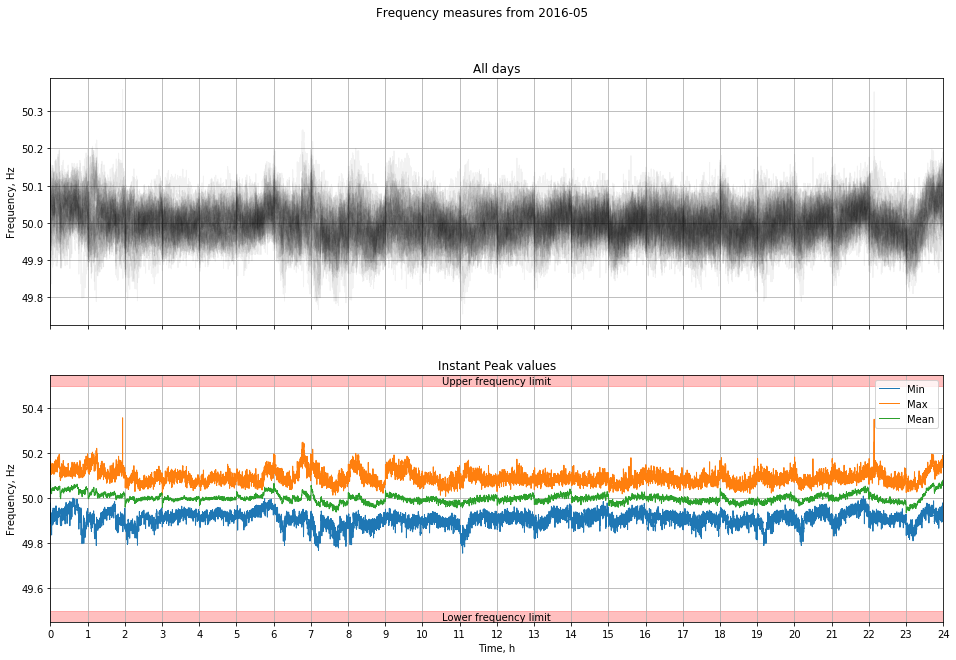

In [8]:
# Create two plot windows on top of each other with shared xand y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)  #, sharey=True)

# Plot all the days against the index
ax1.plot(colindex, val_arr.T, color='k', alpha=.05, linewidth=1)

# Plot hourly limits and mean
ax2.plot(colindex, np.nanmin(val_arr, 0), label='Min', linewidth=1)
ax2.plot(colindex, np.nanmax(val_arr, 0), label='Max', linewidth=1)
ax2.plot(colindex, np.nanmean(val_arr, 0), label='Mean', linewidth=1)

# Beautification
for a in [ax1, ax2]:
    a.grid()
    a.set_xlim(0,24)
    a.set_ylabel('Frequency, Hz')

ax2.set_ylim(49.45, 50.55)

# Operational safety limits
ax2.axhspan(49.45, 49.5, color='red', alpha=.25)  # Critical lower frequency
ax2.axhspan(50.5, 50.55, color='red', alpha=.25)  # Critical upper frequency
ax2.text(colindex.mean(), 49.46, 'Lower frequency limit', horizontalalignment='center')
ax2.text(colindex.mean(), 50.51, 'Upper frequency limit', horizontalalignment='center')

ax2.set_xlabel('Time, h')
ax2.legend()

hidden = ax1.set_xticks(np.arange(0,25))
hidden = plt.suptitle('Frequency measures from {:}'.format(base_date))
hidden = ax1.set_title('All days')
hidden = ax2.set_title('Instant Peak values')

### Does the market structure affect the physical grid? Is there any coordination problem?